In [1]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Get images
X = []
for filename in os.listdir('data/Train/'):
    X.append(img_to_array(load_img('data/Train/'+filename)))
X = np.array(X, dtype=float)

# Set up train and test data
split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

In [3]:
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse')

In [4]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model      
tensorboard = TensorBoard(log_dir="output/first_run")
model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard], epochs=1, steps_per_epoch=10)

Epoch 1/1
10/10 [==============================] - 5s 525ms/step - loss: 0.8304


In [5]:
# Save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [6]:
# Test images
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(model.evaluate(Xtest, Ytest, batch_size=batch_size))

1/1 [==============================] - 0s 167ms/step
0.9750269055366516


/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 51583 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 33944 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 30082 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 53101 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 34388 pixels
  return xyz2rgb(lab2xyz(lab, ill

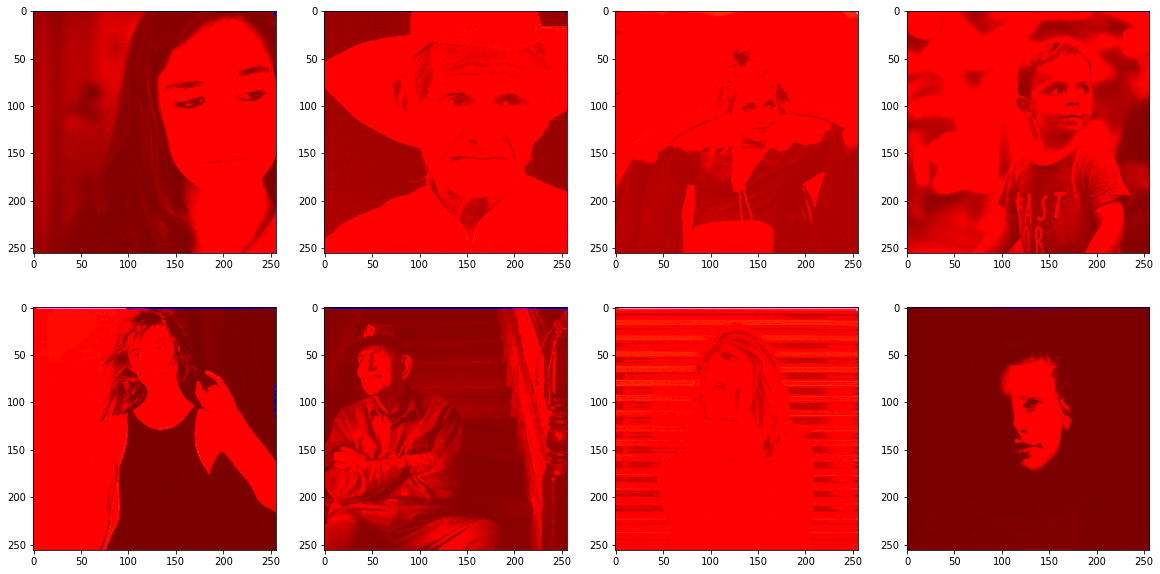

In [9]:
color_me = []
for filename in os.listdir('data/Test/'):
    color_me.append(img_to_array(load_img('data/Test/'+filename)))
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

# Test model
output = model.predict(color_me)
output = output * 128

plt.figure(figsize=(20,10), facecolor='w')
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    plt.subplot(2,4,i + 1)
    plt.imshow(lab2rgb(cur))